In [1]:
import csv
import inspect
import dill
from globus_compute_sdk.serialize import ComputeSerializer
from globus_compute_sdk.serialize.concretes import DillCode, DillCodeSource
from importlib import abc
import codecs
import sys
import ast
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid", font_scale=1.25)

In [2]:
serializer = ComputeSerializer()
header_size = 3

In [53]:
def analyze_function(module, func_name):
    for stmt in ast.walk(module):
        if isinstance(stmt, ast.FunctionDef) and stmt.name == func_name:
            return get_imports(stmt)

def get_imports(code):
    def _strip_dots(pkg):
        if pkg.startswith('.'):
            raise ImportError('On {}, imports from the current module are not supported'.format(pkg))
        return pkg.split('.')[0]

    # Adapted from: https://github.com/cooperative-computing-lab/cctools/blob/master/poncho/src/poncho/package_analyze.py
    imports = set()
    for stmt in ast.walk(code):
        if isinstance(stmt, ast.Import):
            for a in stmt.names:
                imports.add(_strip_dots(a.name))
        elif isinstance(stmt, ast.ImportFrom):
            if stmt.level != 0:
                raise ImportError('On {}, imports from the current module are not supported'.format(stmt.module or '.'))
            imports.add(_strip_dots(stmt.module))
    
    return imports

In [54]:
function_imports = dict()
unique_functions = set()
errors = 0
with open('data/functions.csv') as csvfile:
    reader= csv.DictReader(csvfile)
    for i, row in tqdm(enumerate(reader)):
        function_serialized = row["function_source_code"].partition("\n")[2]
        header = function_serialized[:header_size]
        try:   
            method = serializer.methods_for_code[header]
            
            if isinstance(method, DillCodeSource):
                chomped = method.chomp(function_serialized)
                name, body = dill.loads(codecs.decode(chomped.encode(), "base64"))
            elif isinstance(method, DillCode):
    #             function = method.deserialize(function_serialized)
    #             print(function)
    #             body = dill.source.getsource(function)
                raise NotImplementedError
            
            code = ast.parse(body)
            imports = analyze_function(code, name)
            function_imports[row["function_source_code"]] = imports
        except Exception as e:
            errors += 1

739967it [04:01, 3060.25it/s] 


In [55]:
functions_analyzed = len(function_imports)
functions_registered = i
print(f"Successfully analyzed a total of {functions_analyzed} unique functions")
print(f"Could not analyze {errors} functions out of a total of {functions_registered}")
print(f"Error Rate: {errors/functions_registered}")

Successfully analyzed a total of 10433 unique functions
Could not analyze 14591 functions out of a total of 739966
Error Rate: 0.019718473551487502


In [56]:
function_imports

{'2763\n04\ngASV7gcAAAAAAACMGV9jaGVja19zbHVybV9qb2Jfc3RhdHVzZXOUWMkHAABkZWYgX2NoZWNrX3Ns\ndXJtX2pvYl9zdGF0dXNlcyhqb2JpZHMpOgogICAgIiIiUmV0dXJuIHN0YXR1c2VzIGZvciBnaXZl\nbiBqb2JpZHMiIiIKICAgIGltcG9ydCBzdWJwcm9jZXNzCgogICAgZGVmIHJ1bl9jbWQoY21kKToK\nICAgICAgICBwID0gc3VicHJvY2Vzcy5ydW4oY21kLCB1bml2ZXJzYWxfbmV3bGluZXM9VHJ1ZSwg\nc3Rkb3V0PXN1YnByb2Nlc3MuUElQRSwKICAgICAgICAgICAgICAgICAgICAgICAgICAgc3RkZXJy\nPXN1YnByb2Nlc3MuU1RET1VULCBjaGVjaz1GYWxzZSkKICAgICAgICByZXR1cm4gcC5yZXR1cm5j\nb2RlLCBwLnN0ZG91dC5zdHJpcCgpCgogICAgZGVmIHBhcnNlX291dHB1dChzdG9yZSwgb3V0cHV0\nLCBkZWxpbT1Ob25lKToKICAgICAgICBmb3IgbGluZSBpbiBvdXRwdXQuc3BsaXRsaW5lcygpOgog\nICAgICAgICAgICBpZiBsZW4obGluZS5zdHJpcCgpKToKICAgICAgICAgICAgICAgIHRyeToKICAg\nICAgICAgICAgICAgICAgICBqb2JpZCwgam9ic3RhdGUgPSBsaW5lLnNwbGl0KGRlbGltKQogICAg\nICAgICAgICAgICAgZXhjZXB0IFZhbHVlRXJyb3I6CiAgICAgICAgICAgICAgICAgICAgcGFzcwog\nICAgICAgICAgICAgICAgZWxzZToKICAgICAgICAgICAgICAgICAgICBzdG9yZVtqb2JpZF0gPSBq\nb2JzdGF0ZQoKICAgIHN0YXR1c19kaWN0ID0ge30KICAgIG1zZyA9

In [57]:
df = pd.DataFrame.from_dict({"id": function_imports.keys(), "imports": function_imports.values()})

In [58]:
def length(x):
    try:
        return len(x)
    except:
        return 0
df["num_imports"] = df["imports"].apply(length)

In [59]:
print(f"Averge number of imports: {df['num_imports'].mean()}")

Averge number of imports: 3.2374197258698363


In [60]:
histogram = defaultdict(int)
for func_imports in tqdm(df["imports"]):
    try:
        for m in func_imports:
            histogram[m] += 1
    except:
        continue

100%|█████████████████████████████████████████████████████████| 10433/10433 [00:00<00:00, 826003.24it/s]


In [61]:
histogram

defaultdict(int,
            {'subprocess': 1799,
             'tempfile': 726,
             'os': 5121,
             'hashlib': 101,
             'mtrack': 90,
             'sys': 1920,
             'setproctitle': 12,
             'time': 2405,
             'appfl': 175,
             'collections': 135,
             'torch': 295,
             'psij': 10,
             'json': 1316,
             'home_run': 172,
             're': 214,
             'traceback': 158,
             'eqsql': 2,
             'CLEAN': 10,
             'pandas': 606,
             'pyhf': 93,
             'numpy': 1650,
             'pathlib': 584,
             'pilot': 464,
             'logging': 179,
             'boost_corr': 29,
             'psbench': 57,
             'uuid': 54,
             'dspaces': 11,
             'xpcs_webplot': 9,
             'copy': 32,
             'h5py': 232,
             'datetime': 536,
             'argparse': 22,
             'src': 24,
             'proxystore': 111,
  

In [62]:
sorted_packages = sorted(histogram.keys(), key=lambda x: histogram[x], reverse=True)
sorted_packages

['os',
 'time',
 'sys',
 'shutil',
 'subprocess',
 'numpy',
 'json',
 'xtract_matio_main',
 'requests',
 'tempfile',
 'pandas',
 'random',
 'pathlib',
 'datetime',
 'xtract_sdk',
 'pilot',
 'threading',
 'tensorflow',
 'matplotlib',
 'pickle',
 'mdml_client',
 'glob',
 'torch',
 'XPCS',
 'globus_sdk',
 'io',
 'queue',
 'h5py',
 'cv2',
 're',
 'string',
 'scipy',
 'logging',
 'appfl',
 'home_run',
 'base64',
 'boto3',
 'platform',
 'traceback',
 'exceptions',
 'distutils',
 'psycopg2',
 'math',
 'collections',
 'tarfile',
 'xtract_images_main',
 'zipfile',
 'PIL',
 'readMDML',
 'urllib',
 'abyss',
 'proxystore',
 'boMDML',
 'googleapiclient',
 'rdkit',
 'Kanzus',
 'google_auth_oauthlib',
 'google',
 'hashlib',
 'sklearn',
 'pyhf',
 'concierge',
 'torchvision',
 'mtrack',
 'RaiBaas',
 'socket',
 'braid_db',
 'xtract_keyword_main',
 'coffea',
 'warnings',
 'parsl',
 'fair_research_login',
 'funcx',
 'xtract_tabular_main',
 'csv',
 'zlib',
 'datasketch',
 'stat',
 'pprint',
 'netCDF4',
 'p

In [63]:
filtered_packages = [m for m in sorted_packages if m not in sys.builtin_module_names and m not in sys.stdlib_module_names]
filtered_packages

['numpy',
 'xtract_matio_main',
 'requests',
 'pandas',
 'xtract_sdk',
 'pilot',
 'tensorflow',
 'matplotlib',
 'mdml_client',
 'torch',
 'XPCS',
 'globus_sdk',
 'h5py',
 'cv2',
 'scipy',
 'appfl',
 'home_run',
 'boto3',
 'exceptions',
 'psycopg2',
 'xtract_images_main',
 'PIL',
 'readMDML',
 'abyss',
 'proxystore',
 'boMDML',
 'googleapiclient',
 'rdkit',
 'Kanzus',
 'google_auth_oauthlib',
 'google',
 'sklearn',
 'pyhf',
 'concierge',
 'torchvision',
 'mtrack',
 'RaiBaas',
 'braid_db',
 'xtract_keyword_main',
 'coffea',
 'parsl',
 'fair_research_login',
 'funcx',
 'xtract_tabular_main',
 'datasketch',
 'netCDF4',
 'psbench',
 'CEESD_globus',
 'nonconformity',
 'dataset',
 'skimage',
 'minid',
 'botocore',
 'sqlalchemy',
 'cryptography',
 'azure',
 'core',
 'plotly',
 'GSASIIscriptable',
 'zmq',
 'boost_corr',
 'identify',
 'deriva_datapackage',
 'c2m2_assessment',
 'cfde_ingest',
 'src',
 'pymatgen',
 'mdf_toolbox',
 'ase',
 'cold',
 'dlhub_shim',
 'deriva',
 'cfde_deriva',
 'rtdefec

In [66]:
for package in filtered_packages[:50]:
    print(f"Package: {package}, Count: {histogram[package]}")

Package: numpy, Count: 1650
Package: xtract_matio_main, Count: 745
Package: requests, Count: 740
Package: pandas, Count: 606
Package: xtract_sdk, Count: 487
Package: pilot, Count: 464
Package: tensorflow, Count: 399
Package: matplotlib, Count: 394
Package: mdml_client, Count: 374
Package: torch, Count: 295
Package: XPCS, Count: 287
Package: globus_sdk, Count: 281
Package: h5py, Count: 232
Package: cv2, Count: 219
Package: scipy, Count: 196
Package: appfl, Count: 175
Package: home_run, Count: 172
Package: boto3, Count: 162
Package: exceptions, Count: 154
Package: psycopg2, Count: 146
Package: xtract_images_main, Count: 130
Package: PIL, Count: 122
Package: readMDML, Count: 121
Package: abyss, Count: 114
Package: proxystore, Count: 111
Package: boMDML, Count: 110
Package: googleapiclient, Count: 104
Package: rdkit, Count: 103
Package: Kanzus, Count: 102
Package: google_auth_oauthlib, Count: 102
Package: google, Count: 102
Package: sklearn, Count: 100
Package: pyhf, Count: 93
Package: con

In [2]:
package_stats = pd.read_csv("../results/package_statistics.csv")
package_stats["color"] = 1
package_stats

,Package,Files Accessed,Files Downloaded,color
0,numpy,206,1478,1
1,requests,235,38,1
2,pandas,584,3223,1
3,tensorflow,3563,15403,1
4,matplotlib,302,758,1
5,torch,1485,11534,1
6,globus_sdk,66,395,1
7,h5py,267,149,1
8,opencv-python,47,70,1
9,scipy,225,2203,1


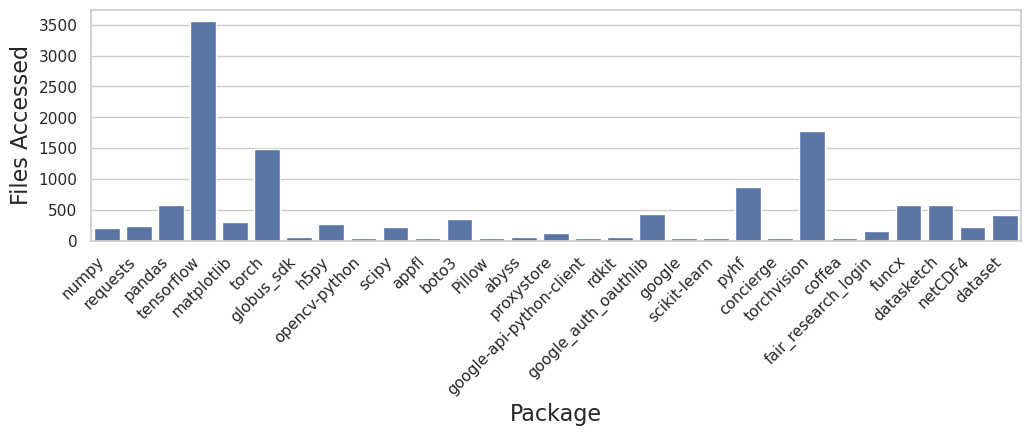

In [4]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.set(style="whitegrid", font_scale=0.75)
sns.barplot(data=package_stats, x="Package", y="Files Accessed", hue="color", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("Package", fontsize=16)
ax.set_ylabel("Files Accessed", fontsize=16)
ax.get_legend().remove()
plt.savefig("figs/package_analysis.pdf", bbox_inches="tight")
plt.show()

In [4]:
package_stats["Files Accessed"].describe()

count      29.000000
mean      446.241379
std       731.901957
min        43.000000
25%        53.000000
50%       225.000000
75%       427.000000
max      3563.000000
Name: Files Accessed, dtype: float64